# Assignment: Linear Models
## Do three questions.

In [9]:
# ! git clone https://github.com/ds4e/linearModels
# %cd data/
# !ls

/content/linearModels/assignment/data
airbnb_hw.csv  cars_hw.csv  heart_failure  heart_hw.csv  pretrial_data.csv  Q1_clean.csv


**Q1.** Please answer the following questions in your own words.

1. What makes a model "linear"? "Linear" in what?

Linear models have linear parameters through coefficients, in which they add weight to the prediction model.

2. How do you interpret the coefficient for a dummy/one-hot-encoded variable? (This is a trick question, and the trick involves how you handle the intercept of the model.)

I guess I'll still answer the trick question, you have to account for the dummy var by omiting.

3. Can linear regression be used for classification? Explain why, or why not.

Yeah technically, although you shouldn't because linear reg doesnt restrict predictions which can lead to inaccuracy.

4. What are signs that your linear model is over-fitting?

A low error on the training set and a poor performance, usually anything that signifies a difference between training and test errors. Abnormal coefficients, also even having too many predictors can make things hazy.

5. Clearly explain multi-colinearity using the two-stage least squares technique.

The extra variables you use to predict your problematic variable are too similar or highly correlated. When this happens, they don’t provide unique information to accurately predict the variable in the first step. Without a strong first-stage prediction, the final estimates in the second stage become unreliable. In a two-stage least squares, the first stage regresses an endogenous predictor on a set of instruments.

6. How can you incorporate nonlinear relationships between your target/response/dependent/outcome variable $y$ and your features/control/response/independent variables $x$ into your analysis?

You add two polynomial or interaction terms, apply transormations to the predictors like logs or square roots, and then use basis expansions to have the relationship bend at certain points.

7. What is the interpretation of the intercept? A slope coefficient for a variable? The coefficient for a dummy/one-hot-encoded variable?

**Intercept**: The baseline predicted value when all predictors equal zero.

**Slope coefficient**: The change in the outcome for a one-unit increase
in the predictor, holding other variables constant.

**Dummy coefficient**: The difference in the outcome between the group with the dummy equal to 1 and the baseline group (dummy = 0).

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

**Q2.** Load `./data/Q1_clean.csv`. The data include

- `Price` per night
- `Review Scores Rating`: The average rating for the property
- `Neighbourhood `: The bourough of NYC. Note the space, or rename the variable.
- `Property Type`: The kind of dwelling
- `Room Type`: The kind of space being rented

1. Compute the average prices and scores by `Neighbourhood `; which bourough is the most expensive on average? Create a kernel density plot of price and log price, grouping by `Neighbourhood `.


Most expensive borough: Manhattan


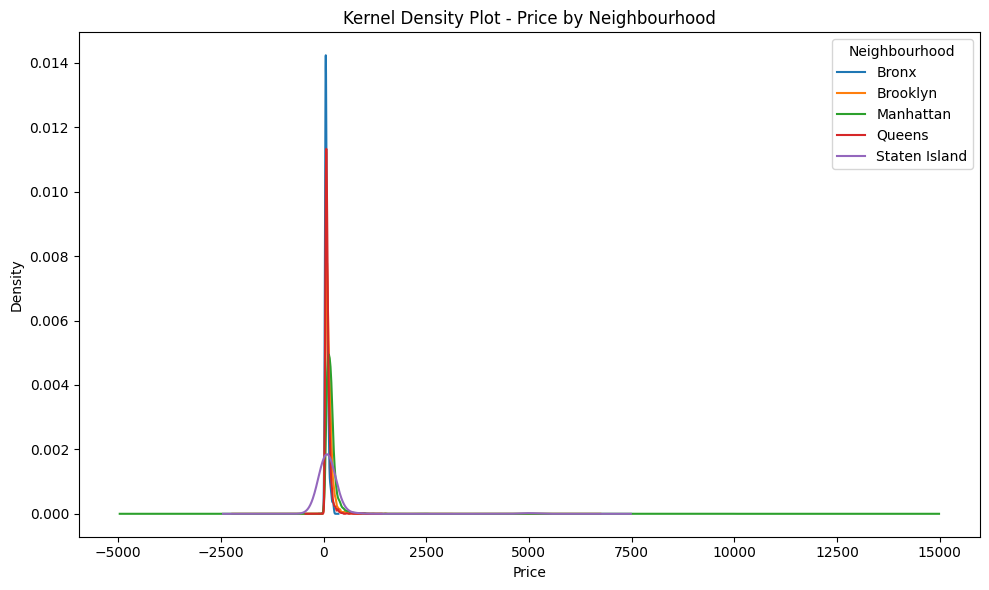

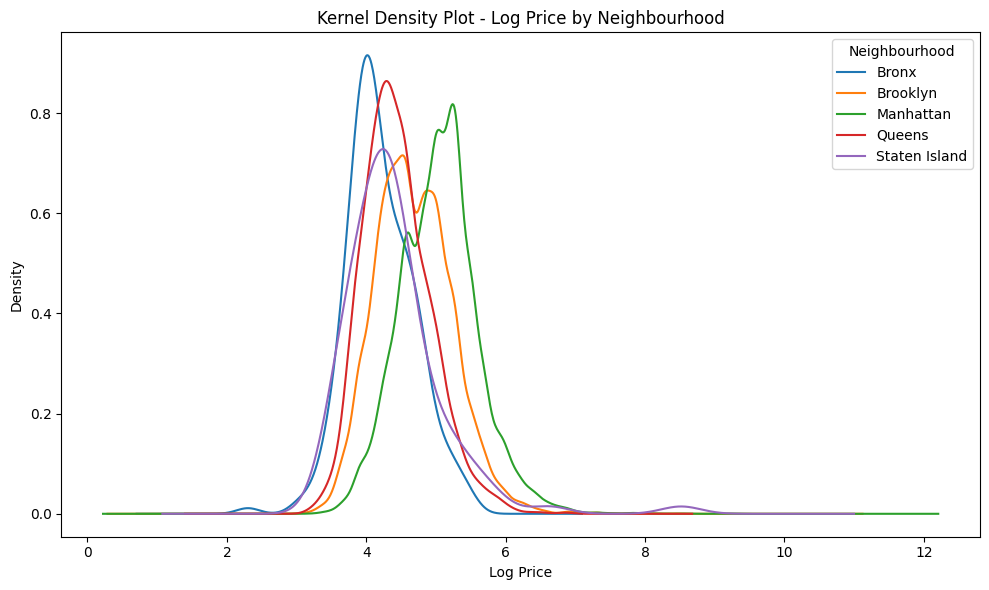

In [14]:
data = pd.read_csv("Q1_clean.csv")
data.rename(columns={'Neighbourhood ': 'Neighbourhood'}, inplace=True)

agg_data = data.groupby('Neighbourhood', as_index=False).agg({
    'Price': 'mean',
    'Review Scores Rating': 'mean'
})

# the most expensive borough (neighbourhood) on average
most_expensive_borough = agg_data.loc[agg_data['Price'].idxmax(), 'Neighbourhood']
print("Most expensive borough:", most_expensive_borough)

# density plot for Price by Neighbourhood
plt.figure(figsize=(10, 6))
for neighbourhood, group in data.groupby('Neighbourhood'):
    group['Price'].plot(kind='kde', label=neighbourhood)
plt.xlabel('Price')
plt.ylabel('Density')
plt.title('Kernel Density Plot - Price by Neighbourhood')
plt.legend(title='Neighbourhood')
plt.tight_layout()
plt.show()

# filter out non-positive prices to safely compute the logarithm
data_positive = data[data['Price'] > 0].copy()
data_positive['Log_Price'] = np.log(data_positive['Price'])

# density plot for Log Price by Neighbourhood
plt.figure(figsize=(10, 6))
for neighbourhood, group in data_positive.groupby('Neighbourhood'):
    group['Log_Price'].plot(kind='kde', label=neighbourhood)
plt.xlabel('Log Price')
plt.ylabel('Density')
plt.title('Kernel Density Plot - Log Price by Neighbourhood')
plt.legend(title='Neighbourhood')
plt.tight_layout()
plt.show()

2. Regress price on `Neighbourhood ` by creating the appropriate dummy/one-hot-encoded variables, without an intercept in the linear model and using all the data. Compare the coefficients in the regression to the table from part 1. What pattern do you see? What are the coefficients in a regression of a continuous variable on one categorical variable?

The regression coefficients exactly match the group-wise means from the table in part which demonstrates that when regressing a continuous variable on one categorical variable The coefficients are simply the group means.

In [17]:
# dummy variables for 'Neighbourhood' (ensuring no intercept)
neighbourhood_dummies = pd.get_dummies(data['Neighbourhood'], dtype=int)

# predictors/dummy variables and response price
X = neighbourhood_dummies
y = data['Price']

# fit a linear regression model without an intercept
regression_model = LinearRegression(fit_intercept=False)
regression_model.fit(X, y)

# regression coefficients, which represent the group-wise mean prices
print("Regression Coefficients (group-wise means):")
print(regression_model.coef_)

# group-wise mean price from the data
mean_price_by_neighbourhood = data.groupby('Neighbourhood')['Price'].mean()
print("\nGroup-wise Mean Prices:")
print(mean_price_by_neighbourhood.head())

Regression Coefficients (group-wise means):
[ 75.2764977  127.74737834 183.66428632  96.8572327  146.16666667]

Group-wise Mean Prices:
Neighbourhood
Bronx             75.276498
Brooklyn         127.747378
Manhattan        183.664286
Queens            96.857233
Staten Island    146.166667
Name: Price, dtype: float64


3. Repeat part 2, but leave an intercept in the linear model. How do you have to handle the creation of the dummies differently? What is the intercept? Interpret the coefficients. How can I get the coefficients in part 2 from these new coefficients?

When including an intercept, one dummy must be dropped to avoid perfect multicollinearity. The intercept is the predicted price for the baseline category 'Bronx'. Each coefficient represents the difference between the mean price of that neighbourhood and the baseline.

To recover the group-wise mean prices add the intercept to the corresponding coefficient. For example, if 'Brooklyn' has a coefficient of 52.47 and the intercept is 75.28, then the mean price for 'Brooklyn' is 75. So when you add 28 and 52.47 you'll get 127.75.


In [18]:
# Create dummy variables for 'Neighbourhood' drop one column (e.g., 'Bronx') avoids the dummy variable trap
intercept_dummies = pd.get_dummies(data['Neighbourhood'], dtype='int', drop_first=True)

# predictors and response variable
X_with_intercept = intercept_dummies
y = data['Price']

# linear regression model with an intercept (default behavior)
intercept_model = LinearRegression().fit(X_with_intercept, y)

# the coefficients for the included dummy variables
print("Coefficients (difference from baseline):")
print(intercept_model.coef_)

# group-wise mean prices for comparison (from part 1)
grouped_mean = data.groupby('Neighbourhood')['Price'].mean()
print("\nGroup-wise Mean Prices:")
print(grouped_mean.head())

# the intercept (which is the mean price for the baseline category, e.g., 'Bronx')
print("\nIntercept (predicted price for the baseline category):")
print(intercept_model.intercept_)

Coefficients (difference from baseline):
[ 52.47088065 108.38778863  21.58073501  70.89016897]

Group-wise Mean Prices:
Neighbourhood
Bronx             75.276498
Brooklyn         127.747378
Manhattan        183.664286
Queens            96.857233
Staten Island    146.166667
Name: Price, dtype: float64

Intercept (predicted price for the baseline category):
75.27649769585331


4. Split the sample 80/20 into a training and a test set. Run a regression of `Price` on `Review Scores Rating` and `Neighbourhood `. What is the $R^2$ and RMSE on the test set? What is the coefficient on `Review Scores Rating`? What is the most expensive kind of property you can rent?

Adding the intercept to a dummy coefficient recovers the group-wise mean price. Thus, the most expensive property is determined by the neighbourhood with the highest intercept + dummy coefficient and would be in Manhattan.


In [22]:
# split the data into training (80%) and testing (20%) sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=31)

# create dummy variables for 'Neighbourhood' for both training and test sets,
train_neighbourhood_dummies = pd.get_dummies(train_data["Neighbourhood"], dtype=int, drop_first=True)
test_neighbourhood_dummies = pd.get_dummies(test_data["Neighbourhood"], dtype=int, drop_first=True)

# combine 'Review Scores Rating' with the dummy variables to create predictor sets
X_train = pd.concat([train_data["Review Scores Rating"], train_neighbourhood_dummies], axis=1)
y_train = train_data["Price"]

X_test = pd.concat([test_data["Review Scores Rating"], test_neighbourhood_dummies], axis=1)
y_test = test_data["Price"]

model = LinearRegression().fit(X_train, y_train)

y_pred = model.predict(X_test)
r2_test = model.score(X_test, y_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

print("Test R^2:", r2_test)
print("Test RMSE:", rmse_test)

coef_df = pd.DataFrame({
    "Variable": X_train.columns,
    "Coefficient": model.coef_
})
print("\nRegression Coefficients:")
print(coef_df)

review_score_coef = coef_df.loc[coef_df["Variable"] == "Review Scores Rating", "Coefficient"].values[0]
print("\nCoefficient for 'Review Scores Rating':", review_score_coef)
print("\nModel Intercept (baseline category mean price):", model.intercept_)


Test R^2: 0.07457356922864677
Test RMSE: 114.92410578609484

Regression Coefficients:
               Variable  Coefficient
0  Review Scores Rating     1.092636
1              Brooklyn    52.468933
2             Manhattan   108.406834
3                Queens    18.860733
4         Staten Island    83.296194

Coefficient for 'Review Scores Rating': 1.0926357256630064

Model Intercept (baseline category mean price): -25.032071802745747


5. Split the sample 80/20 into a training and a test set. Run a regression of `Price` on `Review Scores Rating` and `Neighbourhood ` and `Property Type`. What is the $R^2$ and RMSE on the test set? What is the coefficient on `Review Scores Rating`? What is the most expensive kind of property you can rent?

According to the analysis, the most expensive property type is a townhouse.

In [24]:
# split the data 80/20 into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=31)

# make dummy variables for 'Neighbourhood' (dropping the first category to avoid multicollinearity)
train_neigh_dummies = pd.get_dummies(train_data["Neighbourhood"], dtype=int, drop_first=True)
test_neigh_dummies = pd.get_dummies(test_data["Neighbourhood"], dtype=int, drop_first=True)

# comb dummy variables for 'Property Type' (dropping the first category for a baseline)
train_prop_dummies = pd.get_dummies(train_data["Property Type"], dtype=int, drop_first=True)
test_prop_dummies = pd.get_dummies(test_data["Property Type"], dtype=int, drop_first=True)

# comb the dummy variables with the continuous predictor 'Review Scores Rating'
X_train = pd.concat([train_neigh_dummies, train_prop_dummies, train_data["Review Scores Rating"]], axis=1)
X_test = pd.concat([test_neigh_dummies, test_prop_dummies, test_data["Review Scores Rating"]], axis=1)
# raindex test set to match the training set columns (filling missing columns with 0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

y_train = train_data["Price"]
y_test = test_data["Price"]

# linear regression model (with an intercept by default)
model = LinearRegression().fit(X_train, y_train)

# test set and compute performance metrics
y_pred = model.predict(X_test)
r2_test = model.score(X_test, y_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

print("Test R^2:", r2_test)
print("Test RMSE:", rmse_test)

coef_df = pd.DataFrame({
    "Variable": X_train.columns,
    "Coefficient": model.coef_
})

print("\nRegression Coefficients:")
print(coef_df)
review_scores_coef = coef_df.loc[coef_df["Variable"] == "Review Scores Rating", "Coefficient"].values[0]
print("\nCoefficient for 'Review Scores Rating':", review_scores_coef)
print("\nModel Intercept:", model.intercept_)

Test R^2: 0.08299507791540628
Test RMSE: 114.39999805826464

Regression Coefficients:
                Variable  Coefficient
0               Brooklyn    59.103629
1              Manhattan   120.543503
2                 Queens    23.630859
3          Staten Island    75.432353
4        Bed & Breakfast   -28.928714
5                   Boat    58.554793
6               Bungalow    59.051526
7                  Cabin    37.136703
8              Camper/RV   -19.297445
9                 Castle   -40.866564
10           Condominium    89.964102
11                  Dorm   -47.362701
12                 House    34.671173
13                   Hut  -134.401255
14            Lighthouse   -90.426690
15                  Loft    65.155937
16                 Other     4.567624
17             Townhouse    91.307878
18             Treehouse     9.851495
19                 Villa    36.541869
20  Review Scores Rating     1.077551

Coefficient for 'Review Scores Rating': 1.0775514854554729

Model Intercept: 

6. What does the coefficient on `Review Scores Rating` mean if it changes from part 4 to 5? Hint: Think about how multilple linear regression works.

The coefficient on Review Scores Rating changes because including Property Type in part 5 allows the model to isolate the effect of the review score while controlling for differences across property types. This results in a lower coefficient, indicating that some of the effect attributed to the rating in part 4 was actually due to variations in property type.

7. (**Optional**) We've included `Neighborhood ` and `Property Type` separately in the model. How do you interact them, so you can have "A bedroom in Queens" or "A townhouse in Manhattan". Split the sample 80/20 into a training and a test set and run a regression including that kind of "property type X neighborhood" dummy, plus `Review Scores Rating`. How does the slope coefficient for `Review Scores Rating`, the $R^2$, and the RMSE change? Do they increase significantly compares to part 5? Are the coefficients in this regression just the sum of the coefficients for `Neighbourhood ` and `Property Type` from 5? What is the most expensive kind of property you can rent?

The coefficient for Review Scores Rating remains about 1.07, with only slight changes in R² and RMSE, meaning interaction terms doesn’t  improve model fit. Most expensive property is a Manhattan Townhouse.

In [26]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=31)

train_data['Neigh_Prop'] = train_data['Neighbourhood'] + "_" + train_data['Property Type']
test_data['Neigh_Prop'] = test_data['Neighbourhood'] + "_" + test_data['Property Type']

train_interact_dummies = pd.get_dummies(train_data['Neigh_Prop'], drop_first=True, dtype=int)
test_interact_dummies = pd.get_dummies(test_data['Neigh_Prop'], drop_first=True, dtype=int)

X_train = pd.concat([train_data["Review Scores Rating"], train_interact_dummies], axis=1)
X_test = pd.concat([test_data["Review Scores Rating"], test_interact_dummies], axis=1)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

y_train = train_data["Price"]
y_test = test_data["Price"]

interaction_model = LinearRegression().fit(X_train, y_train)

y_pred = interaction_model.predict(X_test)
r2_test = interaction_model.score(X_test, y_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

print("Test R^2:", r2_test)
print("Test RMSE:", rmse_test)

coef_df = pd.DataFrame({
    "Variable": X_train.columns,
    "Coefficient": interaction_model.coef_
})
print("\nRegression Coefficients:")
print(coef_df)

review_coef = coef_df.loc[coef_df["Variable"] == "Review Scores Rating", "Coefficient"].values[0]
print("\nCoefficient for 'Review Scores Rating':", review_coef)
print("\nModel Intercept:", interaction_model.intercept_)

mean_rating = train_data["Review Scores Rating"].mean()
# Get the coefficients for interaction dummies (excluding the continuous variable)
interaction_coefs = coef_df[coef_df["Variable"] != "Review Scores Rating"].copy()
# Compute predicted price for each interaction group at the average review rating
interaction_coefs["PredictedPrice"] = interaction_model.intercept_ + interaction_model.coef_[0] * mean_rating + interaction_coefs["Coefficient"]
print("\nPredicted Prices for each (Neighbourhood X Property Type) combination (using average review score):")
print(interaction_coefs.sort_values(by="PredictedPrice", ascending=False))

Test R^2: 0.08097927119133463
Test RMSE: 114.52566897080125

Regression Coefficients:
                         Variable  Coefficient
0            Review Scores Rating     1.065489
1           Bronx_Bed & Breakfast    -4.740572
2                     Bronx_House    -5.079635
3                      Bronx_Loft    35.904265
4                 Bronx_Townhouse    32.390407
5              Brooklyn_Apartment    47.281894
6        Brooklyn_Bed & Breakfast    15.337273
7                   Brooklyn_Boat    20.259428
8              Brooklyn_Camper/RV   -23.020189
9            Brooklyn_Condominium    86.149316
10                  Brooklyn_Dorm     1.741200
11                 Brooklyn_House    74.653763
12            Brooklyn_Lighthouse   -46.068019
13                  Brooklyn_Loft    71.008926
14                 Brooklyn_Other    44.067965
15             Brooklyn_Townhouse   108.251661
16             Brooklyn_Treehouse   225.586875
17            Manhattan_Apartment   102.737580
18      Manhattan_Bed

**Q3.** This question is a case study for linear models. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.


In [28]:
cars_df = pd.read_csv("cars_hw.csv")

# Clean the 'No_of_Owners' column by removing ordinal suffixes and converting to integer
cars_df["No_of_Owners"] = cars_df["No_of_Owners"].str.replace("st|nd|rd|th", "", regex=True).astype(int)
cars_df.drop_duplicates(inplace=True)

cars_df['Price_ihs'] = np.arcsinh(cars_df['Price'])
cars_df['Mileage_Run_ihs'] = np.arcsinh(cars_df['Mileage_Run'])

print("Shape:", cars_df.shape)
print(cars_df.head())
print(cars_df.info())

Shape: (976, 14)
   Unnamed: 0        Make  Make_Year   Color  Body_Type  Mileage_Run  \
0           1  Volkswagen       2017  silver      sedan        44611   
1           2     Hyundai       2016     red  crossover        20305   
2           3       Honda       2019   white        suv        29540   
3           4     Renault       2017  bronze  hatchback        35680   
4           5     Hyundai       2017  orange  hatchback        25126   

   No_of_Owners  Seating_Capacity Fuel_Type Transmission Transmission_Type  \
0             1                 5    diesel      7-Speed         Automatic   
1             1                 5    petrol      5-Speed            Manual   
2             2                 5    petrol      5-Speed            Manual   
3             1                 5    petrol      5-Speed            Manual   
4             1                 5    petrol      5-Speed            Manual   

    Price  Price_ihs  Mileage_Run_ihs  
0  657000  14.088586        11.398883  
1

  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?

From the output, MG, Kia, and Jeep are among the most expensive brands.

Price Summary:
count    976.000000
mean      14.104181
std        0.450276
min       12.837344
25%       13.765795
50%       14.102942
75%       14.384228
max       15.587407
Name: Price_ihs, dtype: float64


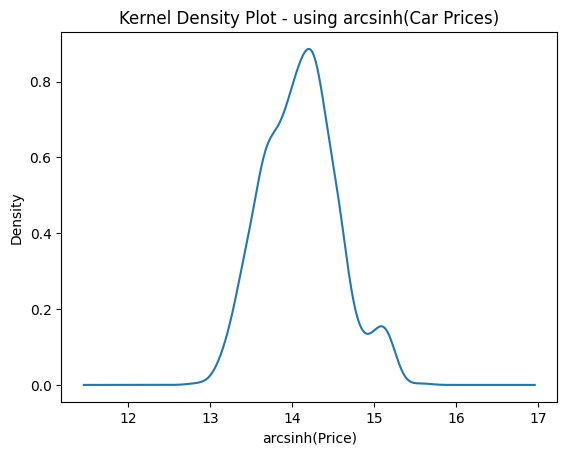

Price by Brand:
               count       mean       std        min        25%        50%  \
Make                                                                         
Chevrolet        6.0  13.613042  0.480975  13.188151  13.261539  13.445433   
Datsun           3.0  13.269194  0.036311  13.232114  13.251449  13.270783   
Ford            52.0  14.161427  0.210895  13.270783  14.054527  14.162640   
Honda           73.0  14.229465  0.336972  13.356645  13.965653  14.266586   
Hyundai        305.0  14.061658  0.398781  13.114331  13.785051  14.059241   
Jeep             4.0  14.909738  0.105084  14.763300  14.876417  14.933413   
Kia              8.0  14.985324  0.076877  14.822738  14.965389  14.996253   
MG Motors       35.0  15.132199  0.066263  14.971763  15.088892  15.122762   
Mahindra        18.0  14.592100  0.159906  14.280502  14.544955  14.598828   
Maruti Suzuki  293.0  13.911280  0.371409  13.068963  13.619496  13.868103   
Nissan           4.0  14.334341  0.392610  13.76

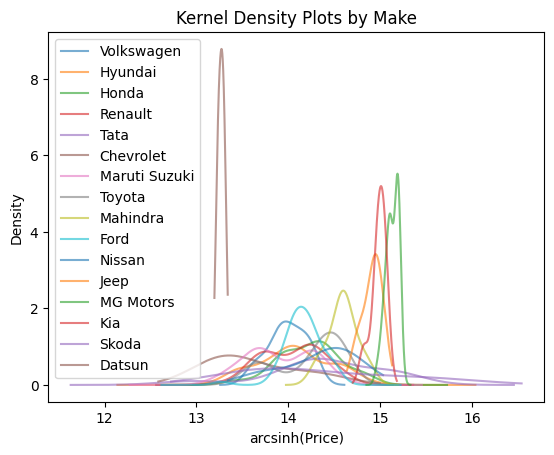

Mean Price by Make:
Make
MG Motors        1.869457e+06
Kia              1.614750e+06
Jeep             1.499500e+06
Skoda            1.136000e+06
Mahindra         1.100167e+06
Tata             1.055217e+06
Nissan           8.842500e+05
Toyota           8.003400e+05
Honda            7.989726e+05
Ford             7.211731e+05
Hyundai          6.918918e+05
Renault          6.625735e+05
Volkswagen       6.058276e+05
Maruti Suzuki    5.887850e+05
Chevrolet        4.535000e+05
Datsun           2.896667e+05
Name: Price, dtype: float64
Mean arcsinh(Price) by Make
Make
MG Motors        15.132199
Kia              14.985324
Jeep             14.909738
Mahindra         14.592100
Tata             14.406552
Nissan           14.334341
Skoda            14.334011
Honda            14.229465
Toyota           14.228654
Ford             14.161427
Hyundai          14.061658
Renault          14.044009
Volkswagen       13.987889
Maruti Suzuki    13.911280
Chevrolet        13.613042
Datsun           13.269194
Na

In [31]:
# Overall summary of arcsinh-transformed car prices
price_summary = cars_df["Price_ihs"].describe()
print("Price Summary:")
print(price_summary)

# density plot for arcsinh(Price)
plt.figure()
cars_df["Price_ihs"].plot(kind="density")
plt.title("Kernel Density Plot - using arcsinh(Car Prices)")
plt.xlabel("arcsinh(Price)")
plt.ylabel("Density")
plt.show()

# summ. prices by brand using groupby and describe
brand_summary = cars_df.groupby("Make")["Price_ihs"].describe()
print("Price by Brand:")
print(brand_summary)

# kernel density plots by Make
plt.figure()
for brand in cars_df["Make"].unique():
    subset = cars_df[cars_df["Make"] == brand]
    subset["Price_ihs"].plot(kind="density", label=brand, alpha=0.6)
plt.title("Kernel Density Plots by Make")
plt.xlabel("arcsinh(Price)")
plt.ylabel("Density")
plt.legend()
plt.show()

# most expensive brands by mean price
mean_price = cars_df.groupby("Make")["Price"].mean().sort_values(ascending=False)
print("Mean Price by Make:")
print(mean_price)

mean_price_ihs = cars_df.groupby("Make")["Price_ihs"].mean().sort_values(ascending=False)
print("Mean arcsinh(Price) by Make")
print(mean_price_ihs)

  3. Split the data into an 80% training set and a 20% testing set.


In [32]:
train_data, test_data = train_test_split(cars_df, test_size=0.2, random_state=31)
print("Training Data Shape:", train_data.shape)
print("Testing Data Shape:", test_data.shape)

Training Data Shape: (780, 14)
Testing Data Shape: (196, 14)


  4. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the training set and test set? Make a second model where, for the categorical variables, you regress price on a model comprised of one-hot encoded regressors/features alone (you can use `pd.get_dummies()`; be careful of the dummy variable trap); what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?

  The categorical-only model outperforms the numeric-only model on the test set.
  The combined model performs slightly better than the categorical-only model.

In [40]:
numeric_vars = ["Make_Year", "Mileage_Run", "Seating_Capacity"]
categorical_vars = ["Color", "Body_Type", "Make", "Fuel_Type", "Transmission_Type"]

# Response variable
y_train = train_data["Price_ihs"]
y_test = test_data["Price_ihs"]

# Numeric-Only Model ---------
X_train_num = train_data[numeric_vars]
X_test_num = test_data[numeric_vars]

num_model = LinearRegression().fit(X_train_num, y_train)
y_train_pred_num = num_model.predict(X_train_num)
y_test_pred_num = num_model.predict(X_test_num)

print("Numeric-Only Model:")
print("  Train R^2:", r2_score(y_train, y_train_pred_num))
print("  Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred_num)))
print("  Test R^2:", r2_score(y_test, y_test_pred_num))
print("  Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_num)))
print()

# Categorical-Only Model ---------
X_train_cat = pd.get_dummies(train_data[categorical_vars], drop_first=True)
X_test_cat = pd.get_dummies(test_data[categorical_vars], drop_first=True)
# Align test data columns with training data columns
X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)

cat_model = LinearRegression().fit(X_train_cat, y_train)
y_train_pred_cat = cat_model.predict(X_train_cat)
y_test_pred_cat = cat_model.predict(X_test_cat)

print("Categorical-Only Model:")
print("  Train R^2:", r2_score(y_train, y_train_pred_cat))
print("  Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred_cat)))
print("  Test R^2:", r2_score(y_test, y_test_pred_cat))
print("  Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_cat)))
print()

# Combined Model (Numeric + Categorical) ---------
X_train_all = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_all = pd.concat([X_test_num, X_test_cat], axis=1)

all_model = LinearRegression().fit(X_train_all, y_train)
y_train_pred_all = all_model.predict(X_train_all)
y_test_pred_all = all_model.predict(X_test_all)

print("Combined Model:")
print("  Train R^2:", r2_score(y_train, y_train_pred_all))
print("  Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred_all)))
print("  Test R^2:", r2_score(y_test, y_test_pred_all))
print("  Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_all)))


Numeric-Only Model:
  Train R^2: 0.422576311523038
  Train RMSE: 0.3526267186871326
  Test R^2: 0.33916922599873556
  Test RMSE: 0.31635113436372486

Categorical-Only Model:
  Train R^2: 0.6627220261517857
  Train RMSE: 0.2695019474072046
  Test R^2: 0.49906254385269155
  Test RMSE: 0.2754330298037643

Combined Model:
  Train R^2: 0.8337616619223771
  Train RMSE: 0.18920539331932132
  Test R^2: 0.7365352313279516
  Test RMSE: 0.19974942625084174


  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using in the regression. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 4?

The best performance is achieved at degree 1 (i.e., the linear model), which has the highest R^2 and lowest RMSE. This model still performs considerably worse than our best model from part 4.

In [39]:
for degree in range(1, 50):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_num)
    X_test_poly = poly.transform(X_test_num)

    poly_model = LinearRegression().fit(X_train_poly, y_train)

    y_train_pred_poly = poly_model.predict(X_train_poly)
    y_test_pred_poly = poly_model.predict(X_test_poly)

    r2_train_poly = r2_score(y_train, y_train_pred_poly)
    rmse_train_poly = np.sqrt(mean_squared_error(y_train, y_train_pred_poly))
    r2_test_poly = r2_score(y_test, y_test_pred_poly)
    rmse_test_poly = np.sqrt(mean_squared_error(y_test, y_test_pred_poly))

    print(f"Degree {degree}:")
    print("  Train R^2:", r2_train_poly)
    print("  Train RMSE:", rmse_train_poly)
    print("  Test R^2:", r2_test_poly)
    print("  Test RMSE:", rmse_test_poly)
    print()

    if r2_test_poly < 0:
        print("Test R^2 went negative at degree:", degree)
        break

Degree 1:
  Train R^2: 0.422576311523038
  Train RMSE: 0.3526267186871326
  Test R^2: 0.33916922599873556
  Test RMSE: 0.31635113436372486

Degree 2:
  Train R^2: 0.45362520946144647
  Train RMSE: 0.3430151042632771
  Test R^2: 0.3358790983820762
  Test RMSE: 0.3171376771051957

Degree 3:
  Train R^2: 0.45703444778077673
  Train RMSE: 0.3419432665870783
  Test R^2: 0.33342142405895625
  Test RMSE: 0.3177239418691621

Degree 4:
  Train R^2: 0.46251605906880033
  Train RMSE: 0.3402128115567437
  Test R^2: 0.3279621446739148
  Test RMSE: 0.3190223685054466

Degree 5:
  Train R^2: 0.4545911910521838
  Train RMSE: 0.3427117476067345
  Test R^2: 0.30727657067822267
  Test RMSE: 0.3238949708580995

Degree 6:
  Train R^2: 0.45611445841033516
  Train RMSE: 0.34223283470594723
  Test R^2: 0.29817946810217066
  Test RMSE: 0.3260147888103447

Degree 7:
  Train R^2: 0.2623577738812317
  Train RMSE: 0.398557331579777
  Test R^2: 0.10556861651016602
  Test RMSE: 0.36804233809771475

Degree 8:
  Train

  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.

   The scatter plot shows that the predicted prices align well along the diagonal, indicating a good fit. The residual density plot is roughly bell-shaped around zero, which means errors are approximately normally distributed.

Strengths: The model fits the data well with predictions clustering around the ideal line and normally distributed residuals.

Weaknesses: The residual spread is relatively large, implying considerable error variance, and the model might benefit from exploring additional non-linear effects or transformations.

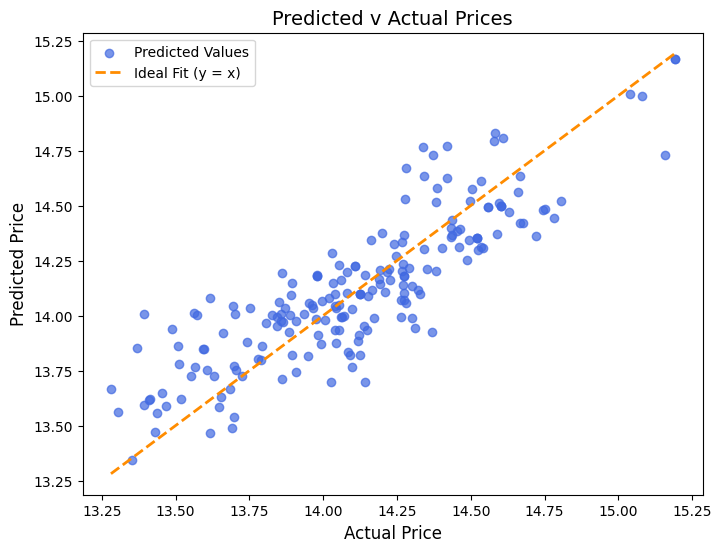

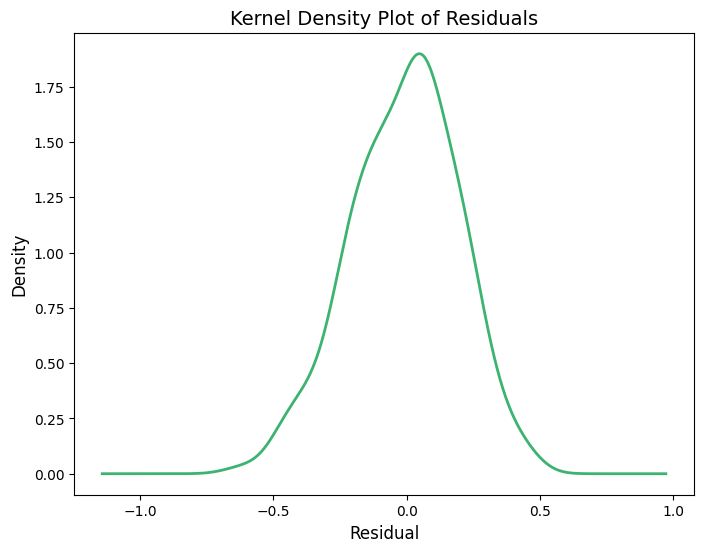

In [42]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred_all, color='royalblue', alpha=0.7, label="Predicted Values")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle='--', color='darkorange', linewidth=2, label="Ideal Fit (y = x)")
plt.xlabel("Actual Price", fontsize=12)
plt.ylabel("Predicted Price", fontsize=12)
plt.title("Predicted v Actual Prices", fontsize=14)
plt.legend()
plt.show()

residuals = y_test - y_test_pred_all
plt.figure(figsize=(8, 6))
pd.Series(residuals).plot(kind="density", color='mediumseagreen', lw=2)
plt.title("Kernel Density Plot of Residuals", fontsize=14)
plt.xlabel("Residual", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.show()